# Basic model building

The main goal is to look at the problem from a different perspective: **build a classifier to predict if a purchase will take place or not** instead of building a regressor to predict the total value of purchase

The original function to flatten json features

In [1]:
# The number of entries to read in. Use it to have fast turn-around
max_events=None
# Number on CV folds
n_cv=5
# Do classifiers
do_clfs=False
# Drop session classifiers, dt_days2Christmas, etc
re_cols_to_drop = ['dt_days2Christmas', 'dt_weekofyear']

import os
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, mean_squared_error, confusion_matrix

PATH = './'
#PATH = '../input/data-preprocessing/'

print(os.listdir(PATH))

['.ipynb_checkpoints', 'add-timezone.ipynb', 'cv_0.csv.gz', 'cv_0_2017-05-01_2017-10-15_2017-12-01_2018-01-31.csv.gz', 'cv_0_2018-01-01_2018-07-02_2018-08-16_2018-10-15.csv.gz', 'cv_1.csv.gz', 'cv_1_2017-11-02_2018-05-03_2018-06-17_2018-08-16.csv.gz', 'cv_2.csv.gz', 'cv_2_2017-09-03_2018-03-04_2018-04-18_2018-06-17.csv.gz', 'data-preprocessing.ipynb', 'flatten-json-fields-smart-dump-data.ipynb', 'lightgbm.ipynb', 'oof_lgbm1log_reg.csv', 'oof_lgbm1_reg.csv', 'sub_lgbm1log_reg.csv', 'sub_lgbm1_reg.csv_subm1', 'sub_lgbm1_reg.csv_subm2', 'test-user.csv.gz', 'test.csv.gz', 'test_2018-05-01_2018-10-15_2018-05-01_2018-10-15.csv.gz', 'train-user.csv.gz', 'y-user.csv.gz', 'ylog-user.csv.gz']


In [2]:
!ls

add-timezone.ipynb
cv_0_2017-05-01_2017-10-15_2017-12-01_2018-01-31.csv.gz
cv_0_2018-01-01_2018-07-02_2018-08-16_2018-10-15.csv.gz
cv_0.csv.gz
cv_1_2017-11-02_2018-05-03_2018-06-17_2018-08-16.csv.gz
cv_1.csv.gz
cv_2_2017-09-03_2018-03-04_2018-04-18_2018-06-17.csv.gz
cv_2.csv.gz
data-preprocessing.ipynb
flatten-json-fields-smart-dump-data.ipynb
lightgbm.ipynb
oof_lgbm1log_reg.csv
oof_lgbm1_reg.csv
sub_lgbm1log_reg.csv
sub_lgbm1_reg.csv_subm1
sub_lgbm1_reg.csv_subm2
test_2018-05-01_2018-10-15_2018-05-01_2018-10-15.csv.gz
test.csv.gz
test-user.csv.gz
train-user.csv.gz
ylog-user.csv.gz
y-user.csv.gz


## Let's load the original data with pre-processing

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and col_type.name != 'category' and 'datetime' not in col_type.name:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif 'datetime' not in col_type.name:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def load_df(fin='../input/train.csv', nrows=None):
    df = pd.read_csv(fin, 
                     dtype={'fullVisitorId': 'str', # Important!!
                           },
                     nrows=nrows)

    print("Loaded {}. Shape: {}".format(os.path.basename(fin), df.shape))
    return reduce_mem_usage(df)

In [4]:
%%time
X_trn = load_df(PATH+'/cv_0_2017-05-01_2017-10-15_2017-12-01_2018-01-31.csv.gz',
            nrows=max_events)

y_trn = X_trn['TARGET']
idx_trn = X_trn['fullVisitorId']

X_trn.drop(['fullVisitorId', 'TARGET'], axis=1, inplace=True)

for re_col in re_cols_to_drop:
    X_trn.drop([c for c in X_trn.columns if re_col in c], axis=1, inplace=True)

Loaded cv_0_2017-05-01_2017-10-15_2017-12-01_2018-01-31.csv.gz. Shape: (329636, 111)
Memory usage of dataframe is 279.16 MB
Memory usage after optimization is: 82.62 MB
Decreased by 70.4%
CPU times: user 12.1 s, sys: 4.02 s, total: 16.1 s
Wall time: 8.3 s


In [5]:
X_tst = load_df(PATH+'/test.csv.gz',
            nrows=max_events)

hasTarget=False
if 'TARGET'in X_tst.columns:
    y_tst = X_tst['TARGET']
    hasTarget=True
idx_tst = X_tst['fullVisitorId']

X_tst.drop(['fullVisitorId'], axis=1, inplace=True)
if hasTarget:
    X_tst.drop(['TARGET'], axis=1, inplace=True)

for re_col in re_cols_to_drop:
    X_tst.drop([c for c in X_tst.columns if re_col in c], axis=1, inplace=True)

Loaded test.csv.gz. Shape: (296530, 110)
Memory usage of dataframe is 248.86 MB
Memory usage after optimization is: 72.78 MB
Decreased by 70.8%


In [6]:
X_trn.head()

,channelGrouping,visitNumber,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,...,frac_revenue_2M,totals_hits_MAX_2M,totals_hits_MEAN_2M,totals_hits_SUM_2M,totals_pageviews_MAX_2M,totals_pageviews_MEAN_2M,totals_pageviews_SUM_2M,totals_timeOnSite_MAX_2M,totals_timeOnSite_MEAN_2M,totals_timeOnSite_SUM_2M
0,2,3,1,0,0.0,1,0,2,9,0,...,0.0,1.0,1.0,3.0,1.0,1.0,3.0,-1.0,-1.0,-3.0
1,5,1,1,0,0.0,0,0,1,13,0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,2,1,1.0,4,33,1,1,14,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1,2,0,0.0,3,2,1,1,1,...,0.0,2.0,2.0,2.0,2.0,2.0,2.0,13.0,13.0,13.0
4,0,1,2,1,1.0,4,0,0,4,0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0


## FeatureEngineering

In [7]:
X_trn.replace(np.inf, 0, inplace=True)

### Data overview

In [8]:
X_trn.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329636 entries, 0 to 329635
Data columns (total 108 columns):
channelGrouping                    int64
visitNumber                        int64
device_browser                     int64
device_deviceCategory              int64
device_isMobile                    float16
device_operatingSystem             int64
geoNetwork_city                    int64
geoNetwork_continent               int64
geoNetwork_country                 int64
geoNetwork_metro                   int64
geoNetwork_networkDomain           int64
geoNetwork_region                  int64
geoNetwork_subContinent            int64
totals_pageviews                   int64
totals_hits                        int64
totals_bounces                     int64
totals_newVisits                   int64
totals_transactionRevenue          int64
totals_visits                      int64
totals_timeOnSite                  int64
totals_sessionQualityDim           int64
trafficSource_adContent  

In [9]:
print(X_trn.shape, y_trn.shape)

(329636, 108) (329636,)


### LGBM extras

In [10]:
import lightgbm as lgb
def learning_rate_decay_power(current_iter):
    base_learning_rate = 5e-2
    min_lr = 5e-3
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > min_lr else min_lr

# Train a pre-processing classifier

In [11]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.base import clone, ClassifierMixin, RegressorMixin

def train_single_model(clf_, X_, y_, random_state_=314, opt_parameters_={}, fit_params_={}):
    c = clone(clf_)
    c.set_params(**opt_parameters_)
    c.set_params(random_state=random_state_)
    return c.fit(X_, y_, **fit_params_)

def fill_signal_stats(y_, stats_, name_='trn'):
    '''
    Fill statistics of the signal distribution
    '''
    y_non_zero = y_.loc[lambda x: x!=0]
    stats_[name_]['min'].append(y_non_zero.min())
    stats_[name_]['max'].append(y_non_zero.max())
    stats_[name_]['mean'].append(y_non_zero.mean())
    stats_[name_]['sum'].append(y_non_zero.sum())
    stats_[name_]['frac'].append(y_non_zero.shape[0] / y_.shape[0])

def train_model_in_CV(model, X, y, metric, metric_args={},
                            model_name='xmodel',
                            seed=31416, n=5,
                            opt_parameters_={}, fit_params_={},
                            verbose=True):
    # the list of classifiers for voting ensable
    clfs = []
    # performance 
    perf_eval = {'score_i_oof': 0,
                 'score_i_ave': 0,
                 'score_i_std': 0,
                 'score_i': [],
                 'signal_stats': {'trn': {'min':[], 'max':[], 'frac':[], 'sum':[], 'mean':[]}, 
                                  'val': {'min':[], 'max':[], 'frac':[], 'sum':[], 'mean':[]}
                                 }
                }
    # full-sample oof prediction
    y_full_oof = pd.Series(np.zeros(shape=(y.shape[0],)), 
                          index=y.index)
    
    if 'sample_weight' in metric_args:
        sample_weight=metric_args['sample_weight']
        
    doSqrt=False
    if 'sqrt' in metric_args:
        doSqrt=True
        del metric_args['sqrt']

    cv = KFold(n, shuffle=True, random_state=seed) #Stratified
    # The out-of-fold (oof) prediction for the k-1 sample in the outer CV loop
    y_oof = pd.Series(np.zeros(shape=(X.shape[0],)), 
                      index=X.index)
    scores = []
    clfs = []

    for n_fold, (trn_idx, val_idx) in enumerate(cv.split(X, (y!=0).astype(np.int8))):
        X_trn, y_trn = X.iloc[trn_idx], y.iloc[trn_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        fill_signal_stats(y_trn, perf_eval['signal_stats'], 'trn')
        fill_signal_stats(y_val, perf_eval['signal_stats'], 'val')

        if fit_params_:
            # use _stp data for early stopping
            fit_params_["eval_set"] = [(X_trn,y_trn), (X_val,y_val)]
            fit_params_['verbose'] = verbose

        clf = train_single_model(model, X_trn, y_trn, 314+n_fold, opt_parameters_, fit_params_)

        clfs.append(('{}{}'.format(model_name,n_fold), clf))
        # evaluate performance
        if isinstance(clf, RegressorMixin):
            y_oof.iloc[val_idx] = clf.predict(X_val)
        elif isinstance(clf, ClassifierMixin):
            y_oof.iloc[val_idx] = clf.predict_proba(X_val)[:,1]
        else:
            raise TypeError('Provided model does not inherit neither from a regressor nor from classifier')
        if 'sample_weight' in metric_args:
            metric_args['sample_weight'] = y_val.map(sample_weight)
        scores.append(metric(y_val, y_oof.iloc[val_idx], **metric_args))
        
        m = metric(y_val, np.zeros(y_val.shape), **metric_args)
        if doSqrt:
            m = np.sqrt(m)
        print('Performance with const=0: {:.4f}'.format(m))
        #cleanup
        del X_trn, y_trn, X_val, y_val

    # Store performance info for this CV
    if 'sample_weight' in metric_args:
        metric_args['sample_weight'] = y_oof.map(sample_weight)
    perf_eval['score_i_oof'] = metric(y, y_oof, **metric_args)
    perf_eval['score_i'] = scores
    
    if doSqrt:
        for k in perf_eval.keys():
            if 'score' in k:
                perf_eval[k] = np.sqrt(perf_eval[k])
        scores = np.sqrt(scores)
            
    perf_eval['score_i_ave'] = np.mean(scores)
    perf_eval['score_i_std'] = np.std(scores)

    return clfs, perf_eval, y_oof

def print_perf_clf(name, perf_eval):
    print('Performance of the model:')    
    print('Mean(Val) score inner {} model: {:.4f}+-{:.4f}'.format(name, 
                                                                      perf_eval['score_i_ave'],
                                                                      perf_eval['score_i_std']
                                                                     ))
    print('Min/max scores on folds: {:.4f} / {:.4f}'.format(np.min(perf_eval['score_i']),
                                                            np.max(perf_eval['score_i'])))
    print('OOF score inner {} model: {:.4f}'.format(name, perf_eval['score_i_oof']))
    print('Scores in individual folds: {}'.format(perf_eval['score_i']))

In [12]:
preproc_clf={}

if do_clfs:
    preproc_clf = {
        'lgbm500_clf': (lgb.LGBMClassifier(max_depth=-1, min_child_samples=400, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000, learning_rate=0.1),
                 {'scale_pos_weight':500, 'colsample_bytree': 0.75, 'min_child_weight': 10.0, 'num_leaves': 32, 'reg_alpha':1, 'subsample': 0.75}, 
                 {"early_stopping_rounds":50, 
                  "eval_metric" : 'auc',
                  'eval_names': ['train', 'early_stop'],
                  'verbose': 100, 
                  'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_decay_power)],
                  'categorical_feature': 'auto'},
                 (y_trn!=0).astype(np.int8)
                ),
#         'lgbm1_clf': (lgb.LGBMClassifier(max_depth=-1, min_child_samples=400, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000, learning_rate=0.1),
#                  {'scale_pos_weight':1, 'colsample_bytree': 0.75, 'min_child_weight': 10.0, 'num_leaves': 32, 'reg_alpha':1, 'subsample': 0.75}, 
#                  {"early_stopping_rounds":50, 
#                   "eval_metric" : 'auc',
#                   'eval_names': ['train', 'early_stop'],
#                   'verbose': 100, 
#                   'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_decay_power)],
#                   'categorical_feature': 'auto'},
#                  (y!=0).astype(np.int8)
#                 ),
        'lgbm1000_clf': (lgb.LGBMClassifier(max_depth=-1, min_child_samples=400, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000, learning_rate=0.1),
                 {'scale_pos_weight':1000, 'colsample_bytree': 0.75, 'min_child_weight': 10.0, 'num_leaves': 32, 'reg_alpha':1, 'subsample': 0.75}, 
                 {"early_stopping_rounds":50, 
                  "eval_metric" : 'auc',
                  'eval_names': ['train', 'early_stop'],
                  'verbose': 100, 
                  'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_decay_power)],
                  'categorical_feature': 'auto'},
                 (y_trn!=0).astype(np.int8)
                ),
        'lgbm100_clf': (lgb.LGBMClassifier(max_depth=-1, min_child_samples=400, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000, learning_rate=0.1),
                 {'scale_pos_weight':100, 'colsample_bytree': 0.75, 'min_child_weight': 10.0, 'num_leaves': 32, 'reg_alpha':1, 'subsample': 0.75}, 
                 {"early_stopping_rounds":50, 
                  "eval_metric" : 'auc',
                  'eval_names': ['train', 'early_stop'],
                  'verbose': 100, 
                  'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_decay_power)],
                  'categorical_feature': 'auto'},
                 (y_trn!=0).astype(np.int8)
                ),
}

In [13]:
%%time
clfss_fe = {}
results_fe = {}
y_oofs_fe = {}
for name, (clf, clf_pars, fit_pars, y_) in preproc_clf.items():
    print('--------------- {} -----------'.format(name))
    clfs_, perf_eval, y_full_oof = train_model_in_CV(clf, X_trn, y_, roc_auc_score, 
                                                          metric_args={},
                                                          model_name=name, 
                                                          opt_parameters_=clf_pars,
                                                          fit_params_=fit_pars, 
                                                          n=n_cv,
                                                          verbose=1000)
    results_fe[name] = perf_eval
    clfss_fe[name] = clfs_
    y_oofs_fe[name] = y_full_oof
    print_perf_clf(name, perf_eval)

CPU times: user 46 µs, sys: 12 µs, total: 58 µs
Wall time: 18.8 µs


In [14]:
for name_clf in preproc_clf.keys():
    print('\nConfusion matrix of {} CLF:'.format(name_clf))
    print(pd.DataFrame(confusion_matrix((y_trn!=0).astype(np.int8), y_oofs_fe[name_clf]>0.5),
          columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

In [15]:
y_clf_fe = {}
for c in preproc_clf:
    clfs_= clfss_fe[c]
    y_sub = np.zeros(idx_tst.shape)
    for clf_ in clfs_:
        y_sub += clf_[1].predict_proba(X_tst)[:,1]
    y_sub /= len(clfs_)
    
    y_clf_fe[c] = y_sub

# Train a model

In [16]:
from sklearn.ensemble import ExtraTreesRegressor
clf_inputs = {

        'lgbm1_reg': (lgb.LGBMRegressor(max_depth=-1, min_child_samples=400, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000, learning_rate=0.05),
                 {'colsample_bytree': 0.715, 'min_child_weight': 10.0, 'num_leaves': 32, 'reg_alpha': 5, 'subsample': 0.756}, 
                 {"early_stopping_rounds":100, 
                  "eval_metric" : 'rmse',
                  'eval_names': ['train', 'early_stop'],
                  'verbose': 100, 
                  'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_decay_power)],
                  'categorical_feature': 'auto'},
                 y_trn
                ),
       }

In [17]:
%%time
clfss = {}
results = {}
y_full_oofs = {}
for name, (clf, clf_pars, fit_pars, y_) in clf_inputs.items():
    print('--------------- {} -----------'.format(name))
    print(X_trn.shape, y_.shape)
    clfs_, perf_eval, y_full_oof = train_model_in_CV(clf, X_trn, y_, mean_squared_error, 
                                                          metric_args={'sqrt': True},
                                                          model_name=name, 
                                                          opt_parameters_=clf_pars,
                                                          fit_params_=fit_pars, 
                                                          n=n_cv,
                                                          verbose=100)
    results[name] = perf_eval
    clfss[name] = clfs_
    y_full_oofs[name] = y_full_oof
    print_perf_clf(name, perf_eval)

--------------- lgbm1_reg -----------
(329636, 108) (329636,)
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 0.302045	early_stop's rmse: 0.374533
[200]	train's rmse: 0.300726	early_stop's rmse: 0.374378
[300]	train's rmse: 0.300199	early_stop's rmse: 0.374363
Early stopping, best iteration is:
[273]	train's rmse: 0.300335	early_stop's rmse: 0.374359
Performance with const=0: 0.3778
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 0.317902	early_stop's rmse: 0.315781
Early stopping, best iteration is:
[81]	train's rmse: 0.318388	early_stop's rmse: 0.315741
Performance with const=0: 0.3178
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 0.31761	early_stop's rmse: 0.318614
[200]	train's rmse: 0.316364	early_stop's rmse: 0.318555
Early stopping, best iteration is:
[148]	train's rmse: 0.316839	early_stop's rmse: 0.318538
Performance with const=0: 0.3213
Training until validation scores d

In [18]:
print('Model performance on OOF: {:.5f}.\nImprovement wrt zero-prediction: {:.5f}'.format(
    np.sqrt(mean_squared_error(y_trn, y_full_oofs['lgbm1_reg'])),
    np.sqrt(mean_squared_error(y_trn, y_full_oofs['lgbm1_reg']))-np.sqrt(mean_squared_error(y_trn, np.zeros(y_trn.shape))))
     )

Model performance on OOF: 0.32089.
Improvement wrt zero-prediction: -0.00281


In [19]:
for n, y_full_oof in y_full_oofs.items():
    y_ = clf_inputs[n][3]
    print('RMSE of {} without MINUS with 0-clipping: {:.6f}'.format(n,
                                                                                 np.sqrt(mean_squared_error(y_, y_full_oof)) -
                                                                                 np.sqrt(mean_squared_error(y_, y_full_oof.clip_lower(0)))
                                                                                ))

RMSE of lgbm1_reg without MINUS with 0-clipping: 0.000071


In [20]:
perf_eval['signal_stats']

{'trn': {'frac': [0.0002957816979386291,
   0.0003261170456829308,
   0.0003185329283414673,
   0.0003185329283414673,
   0.0003488693977073213],
  'max': [20.83, 21.0, 21.0, 21.0, 21.0],
  'mean': [17.9, 17.97, 18.12, 17.97, 18.05],
  'min': [15.61, 15.5, 15.5, 15.5, 15.5],
  'sum': [1397.0, 1545.0, 1523.0, 1510.0, 1660.0]},
 'val': {'frac': [0.00042470573959470936,
   0.0003033658440396196,
   0.0003337024284435815,
   0.0003337024284435815,
   0.0002123560908277337],
  'max': [21.0, 20.77, 20.83, 19.94, 20.0],
  'mean': [18.28, 18.2, 17.55, 18.12, 17.72],
  'min': [15.5, 16.22, 15.61, 15.99, 16.16],
  'sum': [511.8, 364.0, 386.0, 398.8, 248.1]}}

## Prepare submission

In [21]:
y_subs= {}
for c in clf_inputs:
    clfs_= clfss[c]
    y_sub = np.zeros(idx_tst.shape)
    for clf_ in clfs_:
        y_sub += np.clip(clf_[1].predict(X_tst), 
                         0, 
                         None
                        )
    y_sub /= len(clfs_)
    
    y_subs[c] = y_sub

In [22]:
if hasTarget:
    print('Model performance on a future test set: {:.5f}.\nImprovement wrt zero-prediction: {:.5f}'.format(
    np.sqrt(mean_squared_error(y_tst, y_subs['lgbm1_reg'])),
    np.sqrt(mean_squared_error(y_tst, y_subs['lgbm1_reg']))-np.sqrt(mean_squared_error(y_tst, np.zeros(y_tst.shape))))
     )

## Store submission and OOFs

In [23]:
for c in clf_inputs:
    sub = pd.DataFrame(y_subs[c], index=idx_tst)
    sub.columns = ['PredictedLogRevenue']
    sub.clip_lower(0, inplace=True)
    sub.to_csv('sub_{}.csv'.format(c))
    
#     oof = pd.DataFrame(y_full_oofs[c].values, index=idx_trn)
#     oof.columns = ['OOFTotalLogRevenue']
#     oof.clip_lower(0, inplace=True)
#     oof.to_csv('oof_{}.csv'.format(c))

In [47]:
!ls

add-timezone.ipynb
cv_0_2018-01-01_2018-07-02_2018-08-16_2018-10-15.csv.gz
cv_0.csv.gz
cv_1_2017-11-02_2018-05-03_2018-06-17_2018-08-16.csv.gz
cv_1.csv.gz
cv_2_2017-09-03_2018-03-04_2018-04-18_2018-06-17.csv.gz
cv_2.csv.gz
data-preprocessing.ipynb
flatten-json-fields-smart-dump-data.ipynb
lightgbm.ipynb
oof_lgbm1log_reg.csv
oof_lgbm1_reg.csv
sub_lgbm1log_reg.csv
sub_lgbm1_reg.csv
sub_lgbm1_reg.csv_subm1
test_2018-05-01_2018-10-15_2018-05-01_2018-10-15.csv.gz
test.csv.gz
test-user.csv.gz
train-user.csv.gz
ylog-user.csv.gz
y-user.csv.gz


# Feature importance

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

def display_importances(feature_importance_df_, n_feat=30, silent=False, dump_strs=[], 
                        fout_name=None, title='Features (avg over folds)'):
    '''
    Make a plot of most important features from a tree-based model

    Parameters
    ----------
    feature_importance_df_ : pd.DataFrame
        The input dataframe. 
        Must contain columns `'feature'` and `'importance'`.
        The dataframe will be first grouped by `'feature'` and the mean `'importance'` will be calculated.
        This allows to calculate and plot importance averaged over folds, 
        when the same features appear in the dataframe as many time as there are folds in CV.
    n_feats : int [default: 20]
        The maximum number of the top features to be plotted
    silent : bool [default: False]
        Dump additionsl information, in particular the mean importances for features 
        defined by `dump_strs` and the features with zero (<1e-3) importance
    dump_strs : list of strings [default: []]
        Features containing either of these srings will be printed to the screen
    fout_name : str or None [default: None]
        The name of the file to dump the figure. 
        If `None`, no file is created (to be used in notebooks)
    '''
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[:n_feat].index  
    
    mean_imp = feature_importance_df_[["feature", "importance"]].groupby("feature").mean()
    df_2_neglect = mean_imp[mean_imp['importance'] < 1e-3]
    
    if not silent:
        print('The list of features with 0 importance: ')
        print(df_2_neglect.index.values.tolist())

        pd.set_option('display.max_rows', 500)
        pd.set_option('display.max_columns', 500)
        for feat_prefix in dump_strs:
            feat_names = [x for x in mean_imp.index if feat_prefix in x]
            print(mean_imp.loc[feat_names].sort_values(by='importance', ascending=False))
    del mean_imp, df_2_neglect
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title(title)
    plt.tight_layout()

    if fout_name is not None:
        plt.savefig(fout_name)


In [49]:
model_name = [k for k in clfss.keys() if 'lgbm' in k][0]

The list of features with 0 importance: 
['frac_purchaces_2M', 'frac_purchaces_3M', 'frac_revenue_6M', 'geoNetwork_continent', 'geoNetwork_country_gdp_growth', 'geoNetwork_country_handy', 'geoNetwork_country_internet', 'geoNetwork_country_m2f', 'geoNetwork_country_pop_density', 'geoNetwork_subContinent', 'n_bounces_12M', 'n_bounces_3M', 'n_bounces_6M', 'n_purchases_12M', 'n_purchases_2M', 'n_purchases_3M', 'n_purchases_6M', 'totals_bounces', 'totals_visits', 'trafficSource_adContent', 'trafficSource_campaign']


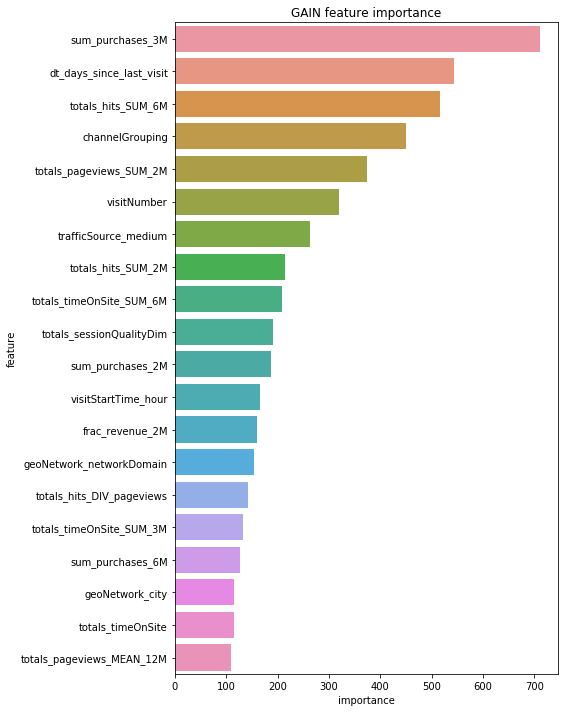

In [50]:
display_importances(pd.DataFrame({'feature': X_trn.columns,
                                  'importance': clfss[model_name][0][1].booster_.feature_importance('gain')}),
                    n_feat=20,
                    title='GAIN feature importance'
                   )

The list of features with 0 importance: 
['frac_purchaces_2M', 'frac_purchaces_3M', 'frac_revenue_6M', 'geoNetwork_continent', 'geoNetwork_country_gdp_growth', 'geoNetwork_country_handy', 'geoNetwork_country_internet', 'geoNetwork_country_m2f', 'geoNetwork_country_pop_density', 'geoNetwork_subContinent', 'n_bounces_12M', 'n_bounces_3M', 'n_bounces_6M', 'n_purchases_12M', 'n_purchases_2M', 'n_purchases_3M', 'n_purchases_6M', 'totals_bounces', 'totals_visits', 'trafficSource_adContent', 'trafficSource_campaign']


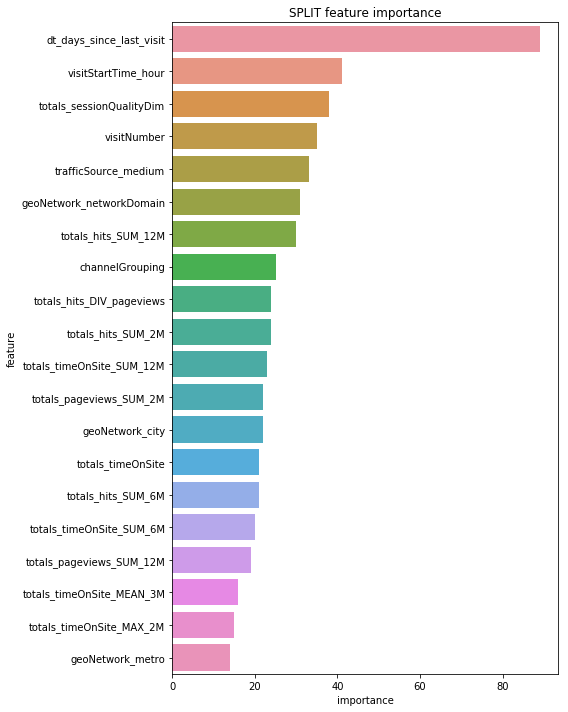

In [51]:
display_importances(pd.DataFrame({'feature': X_trn.columns,
                                  'importance': clfss[model_name][0][1].booster_.feature_importance('split')}),
                    n_feat=20,
                    title='SPLIT feature importance'
                   )

In [52]:
# import shap
# shap_values = shap.TreeExplainer(clfss[model_name][0][1].booster_).shap_values(X_trn)
# shap.summary_plot(shap_values, X_trn, plot_type='bar')

Mean of OOF: 0.0053


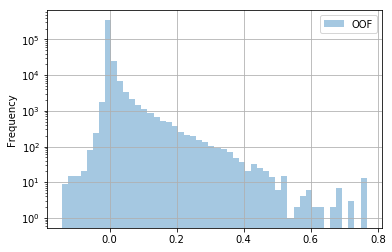

In [114]:
model_name_plot = 'lgbm1_reg' if 'lgbm1_reg' in y_subs.keys() else model_name

print('Mean of OOF: {:.4f}'.format(np.mean(y_full_oofs[model_name_plot])))
#print('Mean of SUB: {:.4f}'.format(np.mean(y_subs[model_name_plot])))

#_ = pd.Series(y_subs[model_name_plot]).plot(kind='hist', logy=True, bins=50, grid=True, legend=True, label='Submission')
_ = y_full_oofs[model_name_plot].plot(kind='hist', logy=True, bins=50, grid=True, legend=True, label='OOF', alpha=0.4)

## Test a model with classifiers added

In [115]:
from sklearn.ensemble import ExtraTreesRegressor
if do_clfs:
    clf_inputs2 = clf_inputs
else:
    clf_inputs2 = {}
# {
#         'lgbm1_reg': (lgb.LGBMRegressor(max_depth=-1, min_child_samples=400, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000, learning_rate=0.05),
#                  {'colsample_bytree': 0.715, 'min_child_weight': 10.0, 'num_leaves': 32, 'reg_alpha': 5, 'subsample': 0.756}, 
#                  {"early_stopping_rounds":100, 
#                   "eval_metric" : 'mse',
#                   'eval_names': ['train', 'early_stop'],
#                   'verbose': 100, 
#                   'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_decay_power)],
#                   'categorical_feature': 'auto'},
#                  y)
#        }

In [117]:
X_trn_tmp = pd.concat([X_trn[[c for c in X_trn.columns if 'lgbm' not in c]], 
                       pd.DataFrame(y_oofs_fe)], 
                      axis=1)
# X_tst_tmp = pd.concat([X_tst[[c for c in X_tst.columns if 'lgbm' not in c]], 
#                        pd.DataFrame(y_clf_fe)],
#                       axis=1)

In [118]:
%%time
clfss = {}
results = {}
y_full_oofs = {}
for name, (clf, clf_pars, fit_pars, y_) in clf_inputs2.items():
    print('--------------- {} -----------'.format(name))
    clfs_, perf_eval, y_full_oof = train_model_in_CV(clf, X_trn_tmp,
                                                     y_, mean_squared_error, 
                                                          metric_args={'sqrt': True},
                                                          model_name=name, 
                                                          opt_parameters_=clf_pars,
                                                          fit_params_=fit_pars, 
                                                          n=n_cv,
                                                          verbose=100)
    results[name] = perf_eval
    clfss[name] = clfs_
    y_full_oofs[name] = y_full_oof
    print_perf_clf(name, perf_eval)

--------------- lgbm1_reg -----------
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 0.298766	early_stop's rmse: 0.307734
Early stopping, best iteration is:
[30]	train's rmse: 0.30122	early_stop's rmse: 0.307479
Performance with const=0: 0.3083
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 0.298437	early_stop's rmse: 0.308901
[200]	train's rmse: 0.297455	early_stop's rmse: 0.308886
Early stopping, best iteration is:
[175]	train's rmse: 0.29761	early_stop's rmse: 0.308874
Performance with const=0: 0.3108
Training until validation scores don't improve for 100 rounds.
[100]	train's rmse: 0.303999	early_stop's rmse: 0.297471
Early stopping, best iteration is:
[68]	train's rmse: 0.30471	early_stop's rmse: 0.297435
Performance with const=0: 0.2988
Performance of the model:
Mean(Val) score inner lgbm1_reg model: 0.3046+-0.0051
Min/max scores on folds: 0.2974 / 0.3089
OOF score inner lgbm1_reg model: 0.3046
Scores in indi

The list of features with 0 importance: 
['device_browser', 'device_deviceCategory', 'device_isMobile', 'frac_revenue_6M', 'geoNetwork_continent', 'geoNetwork_country_gdp_growth', 'geoNetwork_country_handy', 'geoNetwork_country_internet', 'geoNetwork_country_m2f', 'geoNetwork_country_pop_density', 'geoNetwork_country_pop_urban', 'geoNetwork_country_population', 'geoNetwork_country_unemployment', 'geoNetwork_subContinent', 'n_bounces_6M', 'n_purchases_6M', 'totals_bounces', 'totals_transactionRevenue', 'totals_visits', 'trafficSource_adContent', 'trafficSource_campaign']


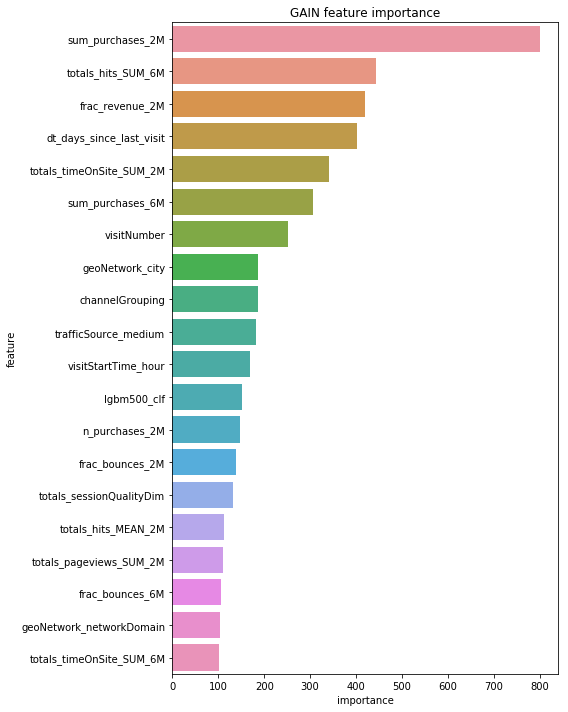

In [119]:
if do_clfs:
    display_importances(pd.DataFrame({'feature': X_trn_tmp.columns,
                                  'importance': clfss[model_name][0][1].booster_.feature_importance('gain')}),
                    n_feat=20,
                    title='GAIN feature importance'
                   )

The list of features with 0 importance: 
['device_browser', 'device_deviceCategory', 'device_isMobile', 'frac_revenue_6M', 'geoNetwork_continent', 'geoNetwork_country_gdp_growth', 'geoNetwork_country_handy', 'geoNetwork_country_internet', 'geoNetwork_country_m2f', 'geoNetwork_country_pop_density', 'geoNetwork_country_pop_urban', 'geoNetwork_country_population', 'geoNetwork_country_unemployment', 'geoNetwork_subContinent', 'n_bounces_6M', 'n_purchases_6M', 'totals_bounces', 'totals_transactionRevenue', 'totals_visits', 'trafficSource_adContent', 'trafficSource_campaign']


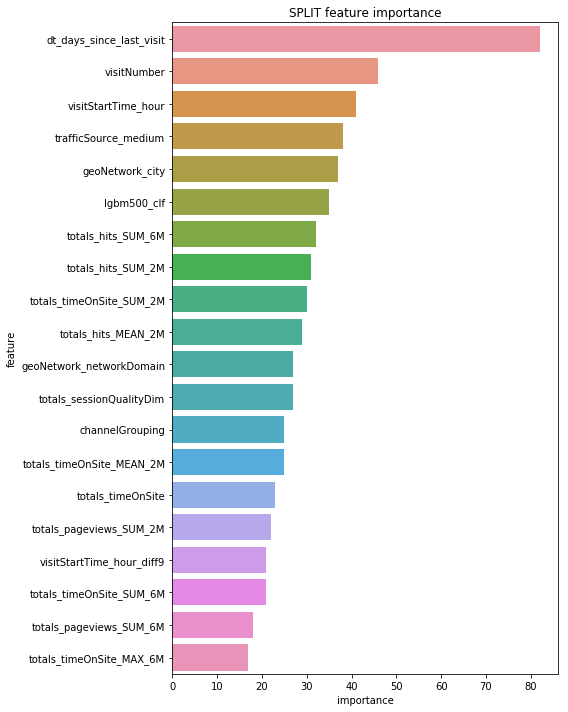

In [120]:
if do_clfs:
    display_importances(pd.DataFrame({'feature': X_trn_tmp.columns,
                                  'importance': clfss[model_name][0][1].booster_.feature_importance('split')}),
                    n_feat=20,
                    title='SPLIT feature importance'
                   )

## Make submission predictions

In [121]:
y_subs= {}
for c in clf_inputs2:
    clfs_= clfss[c]
    y_sub = np.zeros(idx_tst.shape)
    for clf_ in clfs_:
        y_sub += clf_[1].predict(X_tst_tmp)
    y_sub /= len(clfs_)
    
    y_subs[c] = y_sub

NameError: name 'idx_tst' is not defined

In [ ]:
for c in clf_inputs2:
    sub = pd.DataFrame(y_subs[c], index=idx_tst)
    sub.columns = ['PredictedLogRevenue']
    sub.clip_lower(0, inplace=True)
    sub.to_csv('sub_{}_with_CLF.csv'.format(c))
    
    oof = pd.DataFrame(y_full_oofs[c].values, index=idx_trn)
    oof.columns = ['OOFTotalLogRevenue']
    oof.clip_lower(0, inplace=True)
    oof.to_csv('oof_{}_with_CLF.csv'.format(c))

# Under construction....

In [ ]:
# y_train.loc[lambda x: x>0].mean()

In [ ]:
model_name_plot = 'lgbm1_reg' if 'lgbm1_reg' in y_subs.keys() else model_name

In [ ]:
np.mean(y_subs[model_name_plot])

In [ ]:
y_full_oofs[model_name_plot].mean()

In [ ]:
pd.Series(y_subs[model_name_plot]).plot(kind='hist', logy=True, bins=25)

In [ ]:
y_full_oofs[model_name_plot].plot(kind='hist', logy=True, bins=25)

In [ ]:
# y_test.plot(kind='hist', logy=True)

In [ ]:
# 17.8 is the average log1p of the non-0 grouped training data: np.log1p(y.iloc[:,0].loc[lambda x: x>0]).mean()
# sub = pd.DataFrame(y_sub*17.8, index=df_tst_gb.index)

In [ ]:
# sub.columns=['PredictedLogRevenue']

In [ ]:
# sub.to_csv('sub_clf.csv')

In [ ]:
# !head sub_clf.csv